# Exercise 4 $\Longrightarrow$ AirBnB


- James D. Gaboardi
- Filiberto Asare-Akuffo
----
     
     GNU LESSER GENERAL PUBLIC LICENSE
         Version 3, 29 June 2007

     Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>
     Everyone is permitted to copy and distribute verbatim copies
     of this license document, but changing it is not allowed.


----

## Austin, Texas

In [68]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
from pandas.tools.plotting import table
from PIL import Image
import pysal as ps
from scipy.stats import zscore
import seaborn as sns
import sys
import time

%matplotlib inline

mpl.rcParams['figure.figsize'] = 10,10      #set the default map size
mpl.rcParams['patch.linewidth'] = 0.5       #set default polygon line width
mpl.rcParams['markers.fillstyle'] = 'full'  #set default polygon line width

In [69]:
top_directory = "/Users/jgaboardi/Desktop/FSU/FSU_school_work_CPU/"\
                +"Fall_16/Smart_Cities/Exercises/Exercise_4"

# Data Directories
raw_data = top_directory+"/raw_data"
clean_data = top_directory+"/clean_data"
maps_tables_figures = top_directory+"/maps_tables_figures"

---------------

-----------------

# Data Prep

## Study Area

#### I keep the census tracts in the Austin,TX MSA that contained at least one AirBnB and disguarded the remainder

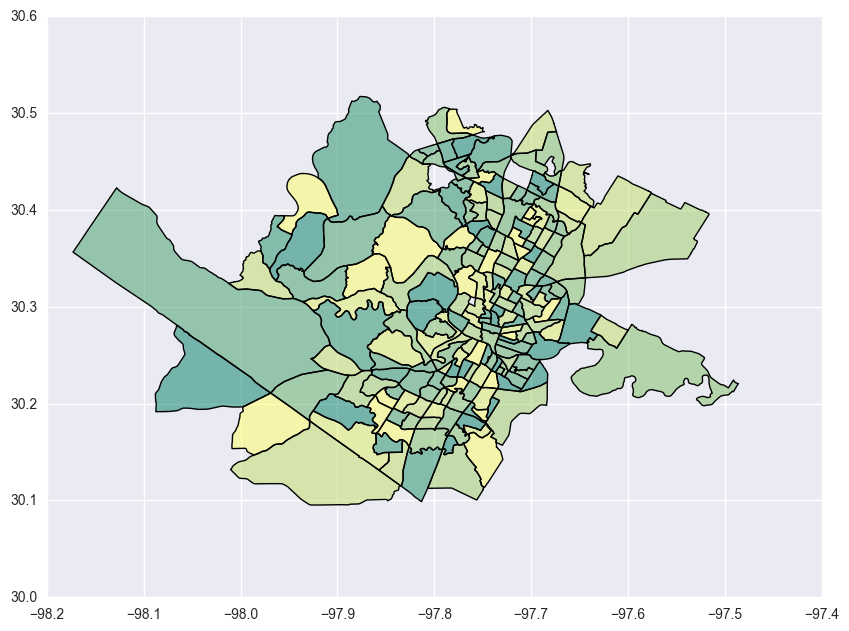

In [70]:
tract_shapes = gpd.read_file(clean_data+"/StudyAreaTracts.shp")
tract_shapes.plot(cmap='summer')

## Variable Calculation

### ACS Variables

In [71]:
acs_data = pd.read_csv(clean_data+"/StudyAreaData.csv")

calculated_acs_variables = pd.DataFrame(acs_data.GISJOIN)

- **transportation**: accessibility to public transportation
    - ***computed as***: proportion of commuters who get to work by transit

In [72]:
trans_columns = ["ABBRE001", # Total Means of Transportation to Work
                 "ABBRE010", # Public transit
                 "ABBRE021"] # Work at home
trans_df = acs_data[trans_columns].copy()
trans_df["transit"] = trans_df.sum(axis=1) - trans_df.ABBRE001 - trans_df.ABBRE021
trans_df["transportation"] = trans_df["transit"]/(trans_df.ABBRE001 - trans_df.ABBRE021)
calculated_acs_variables["transportation"] = trans_df["transportation"]

- **young**
    - ***computed as***: proportion of population between 20 and 34 years old

In [73]:
young_columns = ["ABAQE001", # Total
                 "ABAQE008", # Male: 20 years 
                 "ABAQE009", # Male: 21 years
                 "ABAQE010", # Male: 22 to 24 years
                 "ABAQE011", # Male: 25 to 29 years
                 "ABAQE012", # Male: 30 to 34 years
                 "ABAQE032", # Female: 20 years
                 "ABAQE033", # Female: 21 years
                 "ABAQE034", # Female: 22 to 24 years
                 "ABAQE035", # Female: 25 to 29 years
                 "ABAQE036"] # Female: 30 to 34 years
young_df = acs_data[young_columns].copy()
young_df["20_34"] = young_df.sum(axis=1) - young_df.ABAQE001
young_df["young"] = young_df["20_34"]/young_df.ABAQE001
calculated_acs_variables["young"] = young_df["young"]

- **income**
    - ***computed as***: median household income

In [74]:
calculated_acs_variables["income"] = acs_data["ABDPE001"] # Median HH Income

- **employment**
    - ***computed as***: employed persons as a share of population 16 and older

In [75]:
employment_columns = ["ABAQE001", # Total Population
                      "ABGFE004"] # Employed People
employment_df = acs_data[employment_columns].copy()
employment_df["employment"] = employment_df.ABGFE004 / employment_df.ABAQE001
calculated_acs_variables["employment"] = employment_df["employment"]

- **bohemian**: Based on the work of Richard Florida, the idea that people in the “creative class” contribute disproportionately to the health of a city has been widely studied. There have been a number of variations on defining his group.
    - ***computed as***: proportion of the employed residents working in the “Arts, Design, Entertainment, Sports, And Media Occupations.”

In [76]:
bohemia_columns = ["ABGSE001", # Total Occupation
                   "ABGSE015", # Male Arts
                   "ABGSE051"] # Female Arts
bohemia_df = acs_data[bohemia_columns].copy()
bohemia_df["bohemia"] = (bohemia_df.ABGSE015 
                         + bohemia_df.ABGSE051)/bohemia_df.ABGSE001
calculated_acs_variables["bohemia"] = bohemia_df["bohemia"]

- **melting pot**
    - ***computed as***: proportion of total population born outside the US

In [77]:
foreign_columns = ["ABL8E001", # Foreign-born
                   "ABAQE001"] # US-born
foreign_df = acs_data[foreign_columns].copy()
foreign_df["melting_pot"] = foreign_df.ABL8E001/foreign_df.ABAQE001
calculated_acs_variables["melting_pot"] = foreign_df["melting_pot"]

- **education**
     - ***computed as***: proportion or residents 25 and over with masters or higher

In [78]:
#edu_columns = ["ABC4E"+str(9000+bracket)[1:] for bracket in range(1, 25+1)]
edu_columns = ["ABC4E001", # Total Edu. attainment over 25 yrs.
               "ABC4E023", # Master's degree
               "ABC4E024", # Professional school degree
               "ABC4E025"] # Doctorate degree
edu_df = acs_data[edu_columns].copy()
edu_df[">MS"] = edu_df.sum(axis=1) - edu_df.ABC4E001
edu_df["education"] = edu_df[">MS"]/edu_df.ABC4E001
calculated_acs_variables["education"] = edu_df["education"]

- **substandard**: quality of living and housing that can be considered substandard
    - ***computed as***: proportion of occupied housing units with three or four “selected conditions”

In [79]:
substandard_columns = ["ABZKE001", # Total occupied
                       "ABZKE005", # Owner occupied: With three selected conditions 
                       "ABZKE006", # Owner occupied: With four selected conditions
                       "ABZKE011", # Renter occupied: With three selected conditions
                       "ABZKE012"] # Renter occupied: With four selected conditions
substandard_df = acs_data[substandard_columns].copy()
substandard_df["substd"] = substandard_df.sum(axis=1) - substandard_df.ABZKE001
substandard_df["substandard"] = substandard_df["substd"]/substandard_df.ABZKE001
calculated_acs_variables["substandard"] = substandard_df["substandard"]

- **multifamily**
     - ***computed as***: share of housing units in buildings of 3 or more units

In [80]:
multifam_columns = ["ABHME001", # Total units
                    "ABHME005", # 3 or 4
                    "ABHME006", # 5 to 9
                    "ABHME007", # 10 to 19
                    "ABHME008", # 20 to 49
                    "ABHME009"] # 50 or more
multifam_df = acs_data[multifam_columns].copy()
multifam_df["multi"] = multifam_df.sum(axis=1) - multifam_df.ABHME001
multifam_df["multifamily"] = multifam_df["multi"]/multifam_df.ABHME001
calculated_acs_variables["multifamily"] = multifam_df["multifamily"]

- **rental**
    - ***computed as***: share of occupied housing units rented

In [81]:
rental_columns = ["ABGXE001", # Total occupied
                  "ABGXE003"] # Renter occupied
rental_df = acs_data[rental_columns].copy()                 
rental_df["rental"] = rental_df.ABGXE003/rental_df.ABGXE001
calculated_acs_variables["rental"] = rental_df["rental"]

- **fancy**: high-end housing
     - ***computed as***: percent of owner occupied homes approximately 2 times or more the region median value based on Kiplinger. Table B25075 has discrete bins so the cutoff needs to be estimated.

In [82]:
def roundup(x):
    return int(np.ceil(x / 100000.0)) * 100000

austin_med_sale_price = 225000.
high_end_price = austin_med_sale_price*2
high_end_bin = roundup(high_end_price)
high_end_bin

500000

In [83]:
fancy_columns = ["ABIRE001", # Total Owner-occupied housing units
                 "ABIRE023", # $500,000 to $749,999
                 "ABIRE024", # $750,000 to $999,999
                 "ABIRE025"] # $1,000,000 or more
fancy_df = acs_data[fancy_columns].copy()
fancy_df[">high_end_bin"] = fancy_df.sum(axis=1) - fancy_df.ABIRE001
fancy_df["fancy"] = fancy_df[">high_end_bin"]/fancy_df.ABIRE001
calculated_acs_variables["fancy"] = fancy_df["fancy"]

- **house price**
    - ***computed as***: median home value

In [84]:
calculated_acs_variables["house_price"] = acs_data["ABITE001"] # Median Home Value

- **Simpson Diversity Index**

### $ \displaystyle D = 1 - \sum^5_{g=1} p^2_g $

In [85]:
def simpson(dataframe):
    D = [(1. - np.array([np.square(race_df.iloc[record][group]/race_df.iloc[record].Totals)\
                         for group in race_df if group != "Totals"]).sum())\
                         for record in range(len(dataframe))]
    dataframe["Simpson"] = D
    return dataframe

### example ###
race_df = pd.DataFrame()
white = [800.]
black = [1000.]
asian = [500.]
other = [400.]
hispanic = [1300.]
race_df["White"] = white
race_df["Black"] = black
race_df["Asian"] = asian
race_df["Other"] = other
race_df["Hispanic"] = hispanic
race_df["Totals"] = race_df.sum(axis=1)
simpson(race_df)
race_df.Simpson # Should return approx. 0.766

0    0.76625
Name: Simpson, dtype: float64

In [86]:
race_columns = ["ABBAE"+str(9000+bracket)[1:] for bracket in range(1, 21+1)]
pre_race_df = acs_data[race_columns].copy()
race_df = pd.DataFrame()
race_df["Totals"] = pre_race_df.ABBAE001.astype(float) # Total 
race_df["White"] = pre_race_df.ABBAE003.astype(float)  # White (not hisp)
race_df["Black"] = pre_race_df.ABBAE004.astype(float)  # Black (not hisp)
race_df["Asian"] = pre_race_df.ABBAE006.astype(float)  # Asian (not hisp)
race_df["Other"] = pre_race_df.ABBAE005.astype(float)\
                    + pre_race_df.ABBAE007.astype(float)\
                    + pre_race_df.ABBAE008.astype(float)\
                    + pre_race_df.ABBAE009.astype(float)\
                    + pre_race_df.ABBAE010.astype(float)\
                    + pre_race_df.ABBAE011.astype(float) # All other (not hisp)
race_df["Hispanic"] = pre_race_df.ABBAE012.astype(float) # Hispanis
simpson(race_df)
calculated_acs_variables["Simpson"] = race_df["Simpson"] # Simpson Diversity Index

In [20]:
calculated_acs_variables.to_csv(clean_data+"/calculated_acs_variables.csv")
calculated_acs_variables.head()

,GISJOIN,transportation,young,income,employment,bohemia,melting_pot,education,substandard,multifamily,rental,fancy,house_price,Simpson
0,G4802090010100,0.007529,0.540023,27315.0,0.553927,0.068493,0.044720,0.140044,0.0,0.547833,0.731746,0.100592,158500.0,0.501421
1,G4802090010200,0.000000,0.250507,25429.0,0.250691,0.078818,0.039078,0.148536,0.0,0.420755,0.725581,0.000000,146900.0,0.508790
2,G4802090010302,0.000000,0.387294,34010.0,0.483156,0.000000,0.068506,0.035699,0.0,0.377157,0.719028,0.000000,81900.0,0.467312
3,G4802090010303,0.044884,0.628545,29945.0,0.509191,0.013986,0.073398,0.044628,0.0,0.658652,0.764684,0.000000,56700.0,0.597330
4,G4802090010304,0.082803,0.560688,20752.0,0.493659,0.000000,0.058122,0.025144,0.0,0.798106,0.884047,0.000000,93300.0,0.580127


### GeoNames Variables

In [87]:
interest = gpd.read_file(clean_data+"/StudyAreaInterest.shp")

- **hot_supply**: hotels per square mile (feature code: HTL)

In [44]:
# 1 Sq. Meter = 0.000000386102159 Sq. Mile
hotels = interest[interest.field_8 == "HTL"]
hotels.to_file(clean_data+"/StudyAreaHotels.shp")

- **attractions**: attractions per square mile (not all points are “attractions” so consider which feature codes to use)

In [88]:
attraction_list = ["AMUS", # amusement park
                   "CMN", # common a park
                   "PRK", # park
                   "PRMN", # promenade
                   "RDA", # ancient road
                   "AMTH", # amphitheater
                   "ANS", # archaeological/prehistoric site
                   "BUR", # burial cave(s)
                   "CARN", # cairn
                   "CMP", # camp(s)
                   "CSNO", # casino
                   "CSTL", # castle
                   "CTRS", # space center
                   "MFGB", # brewery
                   "MNMT", # monument
                   "OPRA", # opera house
                   "PAL", # palace
                   "PGDA", # pagoda
                   "RECG", # golf course
                   "RECR", # racetrack
                   "RSRT", # resort
                   "RUIN", # ruin(s)
                   "SHRN", # shrine
                   "SPA", # spa
                   "SQR", # square
                   "THTR", # theater
                   "ZOO", # zoo
                   "FRSTF", # fossilized forest
                   "VIN", # vineyard
                   "VINS"] # vineyards

In [89]:
# 1 Sq. Meter = 0.000000386102159 Sq. Mile
attractions = interest[interest["field_8"].isin(attraction_list)]
attractions.to_file(clean_data+"/StudyAreaAttractions.shp")

### AirBnB Variables

In [90]:
airBnB = gpd.read_file(clean_data+"/Austin_AirBnB.shp")

- **air_supply**: Airbnb properties per square mile
- **air_unit**: Airbnb “Entire home/apt” properties per square mile
- **air_room**: Airbnb “Room” properties per square mile
- **air_demand**: Airbnb reviews per square mile (this is a proxy for number of rentals)

In [91]:
airBnB_units = airBnB[airBnB.room_type == "Entire home/apt"]
airBnB_rooms = airBnB[airBnB.room_type.isin(["Shared room", "Private room"])]

In [23]:
airBnB_units.to_file(clean_data+"/airBnB_units.shp")
airBnB_rooms.to_file(clean_data+"/airBnB_rooms.shp")

## Standardize the data

In [92]:
tract_shapes = gpd.read_file(clean_data+"/StudyAreaTracts.shp")

In [93]:
tract_shapes = tract_shapes.merge(calculated_acs_variables,
                                  on="GISJOIN")
tract_shapes.to_file(clean_data+"/tract_shapes.shp")

In [94]:
variables_list = ["transportation",
                  "young",
                  "income",
                  "employment",
                  "bohemia",
                  "melting_pot",
                  "education",
                  "substandard",
                  "multifamily",
                  "rental",
                  "fancy",
                  "house_price",
                  "Simpson",
                  "hot_supply",
                  "attraction",
                  "air_supply",
                  "air_unit",
                  "air_room",
                  "air_demand"]

### Calculated variables dataframe

In [95]:
tract_variabes_df = tract_shapes[variables_list].copy()
tract_variabes_df = gpd.GeoDataFrame(tract_variabes_df)
tract_variabes_df['geometry'] = tract_shapes.geometry
tract_variabes_df.to_file(clean_data+"/tract_variabes_df.shp")

### $\displaystyle \log(n)$ dataframe

In [96]:
tract_variabes_df_logged = tract_shapes[variables_list].copy()
tract_variabes_df_logged = tract_variabes_df_logged.apply(np.log)
tract_variabes_df_logged = tract_variabes_df_logged.fillna(0.0)
tract_variabes_df_logged = tract_variabes_df_logged.replace(np.inf*-1, 0.0)
tract_variabes_df_logged = gpd.GeoDataFrame(tract_variabes_df_logged)
tract_variabes_df_logged['geometry'] = tract_shapes.geometry
tract_variabes_df_logged.to_file(clean_data+"/tract_variabes_df_logged.shp")

### $\displaystyle z-score$ dataframe

In [97]:
tract_variabes_df_zscore = tract_variabes_df_logged[variables_list].copy()
tract_variabes_df_zscore = pd.DataFrame(zscore(tract_variabes_df_zscore))
tract_variabes_df_zscore = gpd.GeoDataFrame(tract_variabes_df_zscore)
tract_variabes_df_zscore.columns = variables_list
tract_variabes_df_zscore['GISJOIN'] = tract_shapes.GISJOIN
tract_variabes_df_zscore['geometry'] = tract_variabes_df_logged.geometry
tract_variabes_df_zscore.to_file(clean_data+"/tract_variabes_df_zscore.shp")

--------------------------

----------------

# Analysis

## \#1

In [98]:
acs_data = pd.read_csv(clean_data+"/StudyAreaData.csv")
airBnB_units = gpd.read_file(clean_data+"/airBnB_units.shp")
hotels = gpd.read_file(clean_data+"/StudyAreaHotels.shp")

In [99]:
idx = ["Number of census tracts",
       "Total population",
       "Total housing units",
       "Total multifamily housing units",
       "Total rental units",
       "Total Airbnb units",
       "Total Airbnb 'Entire home/apt'",
       "Total Airbnb reviews",
       "Total hotels"]

In [100]:
values = [len(tract_shapes),
          young_df.ABAQE001.sum(),
          multifam_df.ABHME001.sum(),
          multifam_df.multi.sum(),
          rental_df.ABGXE003.sum(),
          len(airBnB),
          len(airBnB_units),
          airBnB.number_of_.sum(),
          len(hotels)]     

In [101]:
number_1 = pd.DataFrame(index=idx)
number_1["Basic Statistics"] = values
number_1.columns.name = "#1"
number_1

#1,Basic Statistics
Number of census tracts,201
Total population,1720438
Total housing units,688720
Total multifamily housing units,209236
Total rental units,274123
Total Airbnb units,5834
Total Airbnb 'Entire home/apt',4059
Total Airbnb reviews,62986
Total hotels,279


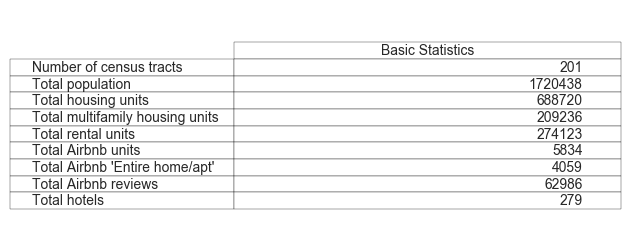

In [102]:
mpl.rcParams['figure.figsize'] = 5,3
mpl.rcParams['patch.linewidth'] = 0.25 

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, number_1, loc='center')  # where df is your data frame

plt.savefig(maps_tables_figures+'/number_1.png', bbox_inches='tight')
plt.show()

------------------

-----------------

# \#2

In [103]:
Austin_MSA = gpd.read_file(clean_data+"/Austin_MSA.shp")
Austin_AirBnB = gpd.read_file(clean_data+"/Austin_AirBnB.shp")
airBnB_units = gpd.read_file(clean_data+"/airBnB_units.shp")
airBnB_rooms = gpd.read_file(clean_data+"/airBnB_rooms.shp")
StudyAreaHotels = gpd.read_file(clean_data+"/StudyAreaHotels.shp")

### MSA, Study Area, & AirBnB

In [104]:
mpl.rcParams['figure.figsize'] = 10,10      
mpl.rcParams['patch.linewidth'] = 0.5      
mpl.rcParams['markers.fillstyle'] = 'full' 

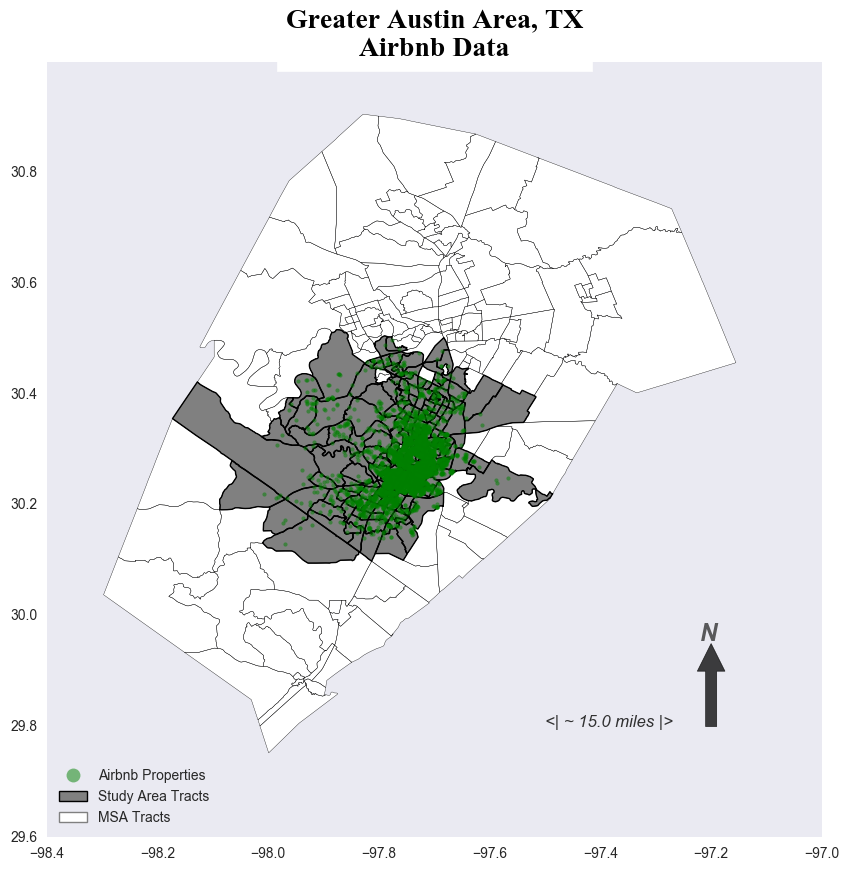

In [105]:
# Austin MSA
base = Austin_MSA.plot(legend=True,
                       cmap=ListedColormap('white'),
                       alpha=1,
                       linewidth=.25)
# Study Area
tract_shapes.plot(ax=base, 
                  markersize=1, 
                  cmap=ListedColormap('gray'),
                  alpha=1)

# AirBnB
Austin_AirBnB.plot(ax=base, 
                   marker='o', 
                   color='green', 
                   markersize=3, 
                   alpha=.5,
                   label="AirBnB")

# Title
plt.title('Greater Austin Area, TX\nAirbnb Data', 
          family='Times New Roman', 
          size=20, 
          color='k', 
          backgroundcolor='w', 
          weight='bold')

plt.grid(False)

# Legend Handles
MSA_Tracts = mpatches.Patch(facecolor='white', 
                            edgecolor='gray', 
                            lw=1, 
                            label='MSA Tracts')
StudyArea_Tracts = mpatches.Patch(facecolor='gray', 
                                  edgecolor='black', 
                                  lw=1, 
                                  label='Study Area Tracts')
AirBnB = mlines.Line2D([], [],
                       color='green', 
                       marker='o',
                       markersize=10, 
                       label='Airbnb Properties', 
                       alpha=.5, 
                       linestyle='None')
# Legend
plt.legend(handles=[AirBnB, StudyArea_Tracts, MSA_Tracts], 
           numpoints=1, 
           loc="lower left", 
           shadow=True, 
           fancybox=True)

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
plt.annotate('N', xy=(-97.22, 29.955), fontstyle='italic', fontsize='xx-large',
             fontweight='heavy', alpha=0.75)
plt.arrow(-97.2, 29.8, 0.0, .1, width=.02, head_width=.05, 
          head_length=.05, fc='k', ec='k',alpha=0.75,)
plt.annotate('<| ~ 15.0 miles |>', xy=(-97.5, 29.8), 
             fontstyle='italic', fontsize='large', alpha=0.95)

plt.savefig(maps_tables_figures+"/number_2_Austin_MSA_AirBnB.png", bbox_inches='tight')

### Study Area, AirBnB, & Hotels

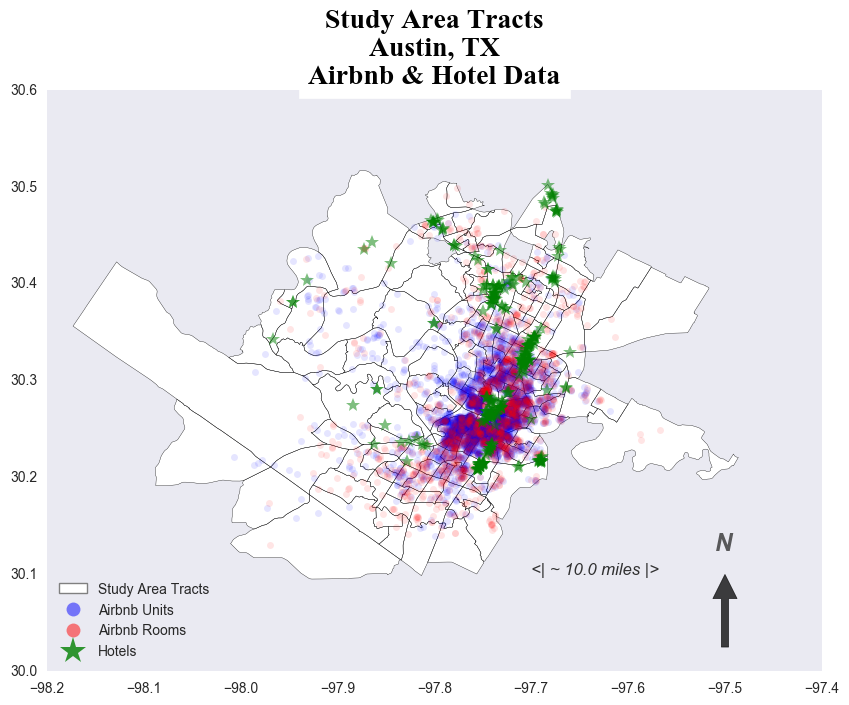

In [106]:
# Base
base = tract_shapes.plot(legend=True,
                         cmap=ListedColormap('white'),
                         alpha=1,
                         linewidth=.25)
# Units
airBnB_units.plot(ax=base, 
                  marker='o', 
                  color='blue', 
                  markersize=5, 
                  alpha=.1,
                  label="AirBnB Units")

# Rooms
airBnB_rooms.plot(ax=base, 
                  marker='o', 
                  color='red', 
                  markersize=5, 
                  alpha=.1,
                  label="AirBnB Rooms")

# Hotels
StudyAreaHotels.plot(ax=base, 
                     marker='*', 
                     color='green', 
                     markersize=10, 
                     alpha=.5,
                     label="Hotels")

# Title
plt.title('Study Area Tracts\nAustin, TX\nAirbnb & Hotel Data', 
          family='Times New Roman', 
          size=20, 
          color='k', 
          backgroundcolor='w', 
          weight='bold')

plt.grid(False)

# Legend Handles
StudyArea_Tracts = mpatches.Patch(facecolor='white', 
                   edgecolor='gray', 
                   lw=1, 
                   label='Study Area Tracts')
AirBnB_Units = mlines.Line2D([], [],
                             color='blue', 
                             marker='o',
                             markersize=10, 
                             label='Airbnb Units', 
                             alpha=.5, 
                             linestyle='None')
AirBnB_Rooms = mlines.Line2D([], [],
                             color='red', 
                             marker='o',
                             markersize=10, 
                             label='Airbnb Rooms', 
                             alpha=.5, 
                             linestyle='None')
Hotels = mlines.Line2D([], [],
                       color='green', 
                       marker='*',
                       markersize=20, 
                       label='Hotels', 
                       alpha=.8, 
                       linestyle='None')


# Legend
plt.legend(handles=[StudyArea_Tracts, AirBnB_Units, AirBnB_Rooms, Hotels], 
           numpoints=1, 
           loc="lower left", 
           shadow=True, 
           fancybox=True)

# North Arrow and 'N' --> Must be changed for different spatial resolutions, etc.
plt.annotate('N', xy=(-97.51, 30.125), fontstyle='italic', fontsize='xx-large',
             fontweight='heavy', alpha=0.75)
plt.arrow(-97.5, 30.025, 0.0, .05, width=.0075, head_width=.025, 
          head_length=.025, fc='k', ec='k',alpha=0.75,)
plt.annotate('<| ~ 10.0 miles |>', xy=(-97.7, 30.1), 
             fontstyle='italic', fontsize='large', alpha=0.95)

plt.savefig(maps_tables_figures+"/number_2_StudyArea_AirBnB_Hotel.png", bbox_inches='tight')

-------------

-------------

# \#4

### Queen Contiguity Matrix

In [107]:
w = ps.queen_from_shapefile(clean_data+"/tract_variabes_df_zscore.shp")

### $ \textit{Global Moran's } I$ for each variable

In [108]:
air_unit_Moran_global = ps.Moran(tract_variabes_df_zscore.air_unit, w, permutations=99999)
air_room_Moran_global = ps.Moran(tract_variabes_df_zscore.air_room, w, permutations=99999)
air_demand_Moran_global = ps.Moran(tract_variabes_df_zscore.air_demand, w, permutations=99999)
hotel_Moran_global = ps.Moran(tract_variabes_df_zscore.hot_supply, w, permutations=99999)

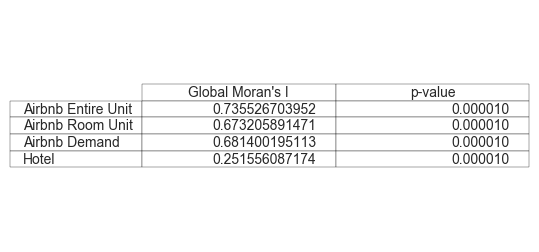

In [109]:
# Figure / Table
values_mi = [air_unit_Moran_global.I, 
             air_room_Moran_global.I, 
             air_demand_Moran_global.I, 
             hotel_Moran_global.I]

values_psim = ['%f' % air_unit_Moran_global.p_sim, 
               '%f' % air_room_Moran_global.p_sim, 
               '%f' % air_demand_Moran_global.p_sim, 
               '%f' % hotel_Moran_global.p_sim]

idx = ["Airbnb Entire Unit",
       "Airbnb Room Unit",
       "Airbnb Demand",
       "Hotel",]

number_4 = pd.DataFrame(index=idx)
number_4["Global Moran's I"] = values_mi
number_4["p-value"] = values_psim

mpl.rcParams['figure.figsize'] = 5,3
mpl.rcParams['patch.linewidth'] = 0.25 

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, number_4, loc='center')  # where df is your data frame

plt.savefig(maps_tables_figures+'/number_4.png', bbox_inches='tight')
plt.show()

In [110]:
significance_levels = [.1, 0.05, 0.005, 0.0005]

## Airbnb Units $ \textit{Local Moran's } I$

In [114]:
for threshold in significance_levels:
# Local Moran's I 
    air_unit_Moran_local = ps.Moran_Local(tract_variabes_df_zscore.air_unit, 
                                          w, 
                                          permutations=99999)
    # df, then geodf
    air_unit_Moran_local_df = pd.DataFrame(tract_variabes_df_zscore.GISJOIN)
    air_unit_Moran_local_df = gpd.GeoDataFrame(air_unit_Moran_local_df)
    air_unit_Moran_local_df["Is"] = air_unit_Moran_local.Is
    air_unit_Moran_local_df["p_sim"] = air_unit_Moran_local.p_sim
    air_unit_Moran_local_df["sig"] = air_unit_Moran_local_df.p_sim < threshold
    air_unit_Moran_local_df['geometry'] = tract_variabes_df_zscore.geometry
    air_unit_Moran_local_df["type"] = air_unit_Moran_local.q
    # slice out insignificant and signficant values
    insig = air_unit_Moran_local_df[air_unit_Moran_local_df["sig"] == False]
    sig = air_unit_Moran_local_df[air_unit_Moran_local_df["sig"] == True]
    high_high = sig[sig["type"] == 1]
    high_low = sig[sig["type"] == 2]
    low_low = sig[sig["type"] == 3]
    low_high = sig[sig["type"] == 4]

    ####################################################################
    # Plot
    mpl.rcParams['figure.figsize'] = 10,10      
    mpl.rcParams['patch.linewidth'] = 0.5      
    mpl.rcParams['markers.fillstyle'] = 'full' 
    # Study Area
    base = tract_shapes.plot(legend=True,
                             cmap=ListedColormap('white'),
                             alpha=1,
                             linewidth=.25)
    # Study Area
    insig.plot(ax=base, 
               cmap=ListedColormap('gray'),
               alpha=1,
               linewidth=.25)
    # HH
    high_high.plot(ax=base, 
                   cmap=ListedColormap('red'),
                   alpha=1,
                   linewidth=.25)
    # HL
    high_low.plot(ax=base, 
                  cmap=ListedColormap('blue'),
                  alpha=.5,
                  linewidth=.25)
    # LH
    low_high.plot(ax=base, 
                  cmap=ListedColormap('red'),
                  alpha=.5,
                  linewidth=.25)
    # LL
    low_low.plot(ax=base, 
                 cmap=ListedColormap('blue'),
                 alpha=1,
                 linewidth=.25)

    # Legend Handles
    NS = mpatches.Patch(facecolor='gray', 
                        edgecolor='black', 
                        lw=1, 
                        label='Insignificant')
    HH = mpatches.Patch(facecolor='red', 
                        edgecolor='black', 
                        lw=1, 
                        label='High-High')
    LL = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        lw=1, 
                        label='Low-Low')
    LH = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        alpha=0.5,
                        lw=1, 
                        label='Low-High')
    HL = mpatches.Patch(facecolor='red', 
                        edgecolor='black',
                        alpha=0.5,
                        lw=1, 
                        label='High-Low')

    # Legend
    plt.legend(handles=[NS, HH, LL, LH, HL], 
               numpoints=1, 
               loc="lower left", 
               shadow=True, 
               framealpha=0.5,
               fancybox=True)

    # Title
    plt.title('Study Area Tracts\nAustin, TX\nLISA Airbnb UNITS', 
              family='Times New Roman', 
              size=20, 
              color='k', 
              backgroundcolor='w', 
              weight='bold')
    plt.grid(False)

    # Annotations must be changed for different spatial resolutions, etc. ###################
    # Permutations
    plt.annotate('Permutations: '+str(air_unit_Moran_local.permutations), 
                 xy=(-98.18, 30.125), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('Significance Threshold: '+str(threshold), 
                 xy=(-98., 30.05), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('N', xy=(-97.51, 30.125), fontstyle='italic', fontsize='xx-large',
                 fontweight='heavy', alpha=0.75)
    plt.arrow(-97.5, 30.025, 0.0, .05, width=.0075, head_width=.025, 
              head_length=.025, fc='k', ec='k',alpha=0.75,)
    plt.annotate('<| ~ 10.0 miles |>', xy=(-97.7, 30.1), 
                 fontstyle='italic', fontsize='large', alpha=0.95)

    # Save out figure
    plt.savefig(maps_tables_figures+"/number_4_UNIT_LISA_"+str(threshold)+".png", 
                bbox_inches='tight')
    plt.close()

### Combine 

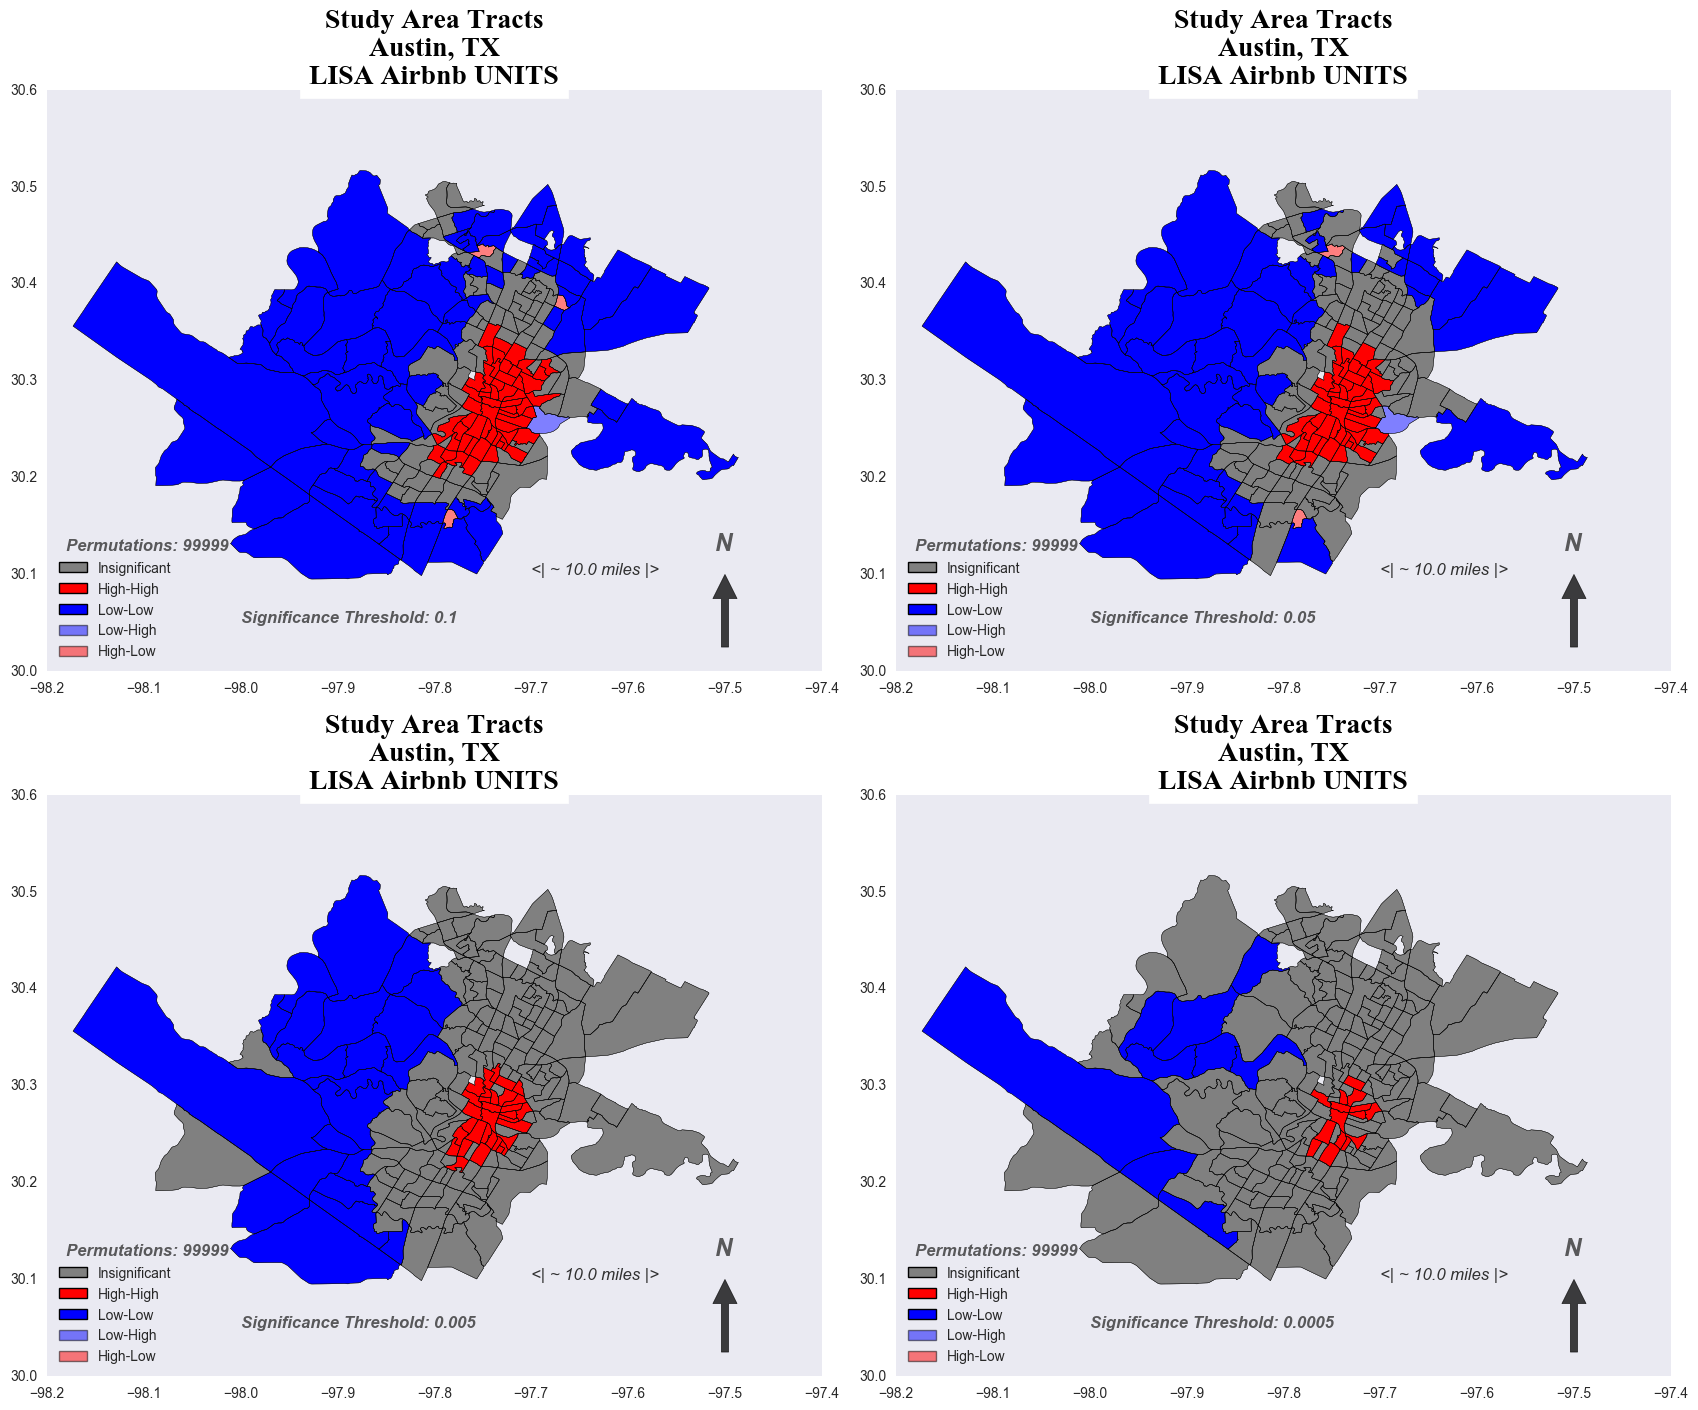

In [115]:
image_dims = (1698,1410)

number_4_UNIT = Image.new("RGB", image_dims, "white")
_1___ = Image.open(maps_tables_figures+"/number_4_UNIT_LISA_0.1.png")
_05__ = Image.open(maps_tables_figures+"/number_4_UNIT_LISA_0.05.png")
_005_ = Image.open(maps_tables_figures+"/number_4_UNIT_LISA_0.005.png")
_0005 = Image.open(maps_tables_figures+"/number_4_UNIT_LISA_0.0005.png")

number_4_UNIT.paste(_1___, (0,0))
number_4_UNIT.paste(_05__, (image_dims[0]/2,0))
number_4_UNIT.paste(_005_, (0,image_dims[1]/2))
number_4_UNIT.paste(_0005, (image_dims[0]/2,image_dims[1]/2))
number_4_UNIT.save(maps_tables_figures+"/number_4_UNIT.png")
number_4_UNIT

## Airbnb Rooms $ \textit{Local Moran's } I$

In [116]:
for threshold in significance_levels:
    # Local Moran's I 
    air_room_Moran_local = ps.Moran_Local(tract_variabes_df_zscore.air_room, 
                                          w, 
                                          permutations=99999)
    # df, then geodf
    air_room_Moran_local_df = pd.DataFrame(tract_variabes_df_zscore.GISJOIN)
    air_room_Moran_local_df = gpd.GeoDataFrame(air_room_Moran_local_df)
    air_room_Moran_local_df["Is"] = air_room_Moran_local.Is
    air_room_Moran_local_df["p_sim"] = air_room_Moran_local.p_sim
    air_room_Moran_local_df["sig"] = air_room_Moran_local.p_sim < threshold
    air_room_Moran_local_df['geometry'] = tract_variabes_df_zscore.geometry
    air_room_Moran_local_df["type"] = air_room_Moran_local.q
    # slice out insignificant and signficant values
    insig = air_room_Moran_local_df[air_room_Moran_local_df["sig"] == False]
    sig = air_room_Moran_local_df[air_room_Moran_local_df["sig"] == True]
    high_high = sig[sig["type"] == 1]
    high_low = sig[sig["type"] == 2]
    low_low = sig[sig["type"] == 3]
    low_high = sig[sig["type"] == 4]

    ####################################################################
    # Plot
    mpl.rcParams['figure.figsize'] = 10,10      
    mpl.rcParams['patch.linewidth'] = 0.5      
    mpl.rcParams['markers.fillstyle'] = 'full' 
    # Study Area
    base = tract_shapes.plot(legend=True,
                             cmap=ListedColormap('white'),
                             alpha=1,
                             linewidth=.25)
    # Study Area
    insig.plot(ax=base, 
               cmap=ListedColormap('gray'),
               alpha=1,
               linewidth=.25)
    # HH
    high_high.plot(ax=base, 
                   cmap=ListedColormap('red'),
                   alpha=1,
                   linewidth=.25)
    # HL
    high_low.plot(ax=base, 
                  cmap=ListedColormap('blue'),
                  alpha=.5,
                  linewidth=.25)
    # LH
    low_high.plot(ax=base, 
                  cmap=ListedColormap('red'),
                  alpha=.5,
                  linewidth=.25)
    # LL
    low_low.plot(ax=base, 
                 cmap=ListedColormap('blue'),
                 alpha=1,
                 linewidth=.25)

    # Legend Handles
    NS = mpatches.Patch(facecolor='gray', 
                        edgecolor='black', 
                        lw=1, 
                        label='Insignificant')
    HH = mpatches.Patch(facecolor='red', 
                        edgecolor='black', 
                        lw=1, 
                        label='High-High')
    LL = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        lw=1, 
                        label='Low-Low')
    LH = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        alpha=0.5,
                        lw=1, 
                        label='Low-High')
    HL = mpatches.Patch(facecolor='red', 
                        edgecolor='black',
                        alpha=0.5,
                        lw=1, 
                        label='High-Low')

    # Legend
    plt.legend(handles=[NS, HH, LL, LH, HL], 
               numpoints=1, 
               loc="lower left", 
               shadow=True, 
               framealpha=0.5,
               fancybox=True)

    # Title
    plt.title('Study Area Tracts\nAustin, TX\nLISA Airbnb ROOMS', 
              family='Times New Roman', 
              size=20, 
              color='k', 
              backgroundcolor='w', 
              weight='bold')
    plt.grid(False)

    # Annotations must be changed for different spatial resolutions, etc. ###################
    # Permutations
    plt.annotate('Permutations: '+str(air_room_Moran_local.permutations), 
                 xy=(-98.18, 30.125), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('Significance Threshold: '+str(threshold), 
                 xy=(-98., 30.05), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('N', xy=(-97.51, 30.125), fontstyle='italic', fontsize='xx-large',
                 fontweight='heavy', alpha=0.75)
    plt.arrow(-97.5, 30.025, 0.0, .05, width=.0075, head_width=.025, 
              head_length=.025, fc='k', ec='k',alpha=0.75,)
    plt.annotate('<| ~ 10.0 miles |>', xy=(-97.7, 30.1), 
                 fontstyle='italic', fontsize='large', alpha=0.95)
    
    # Save out figure
    plt.savefig(maps_tables_figures+"/number_4_ROOM_LISA_"+str(threshold)+".png",
                bbox_inches='tight')
    plt.close()

### Combine

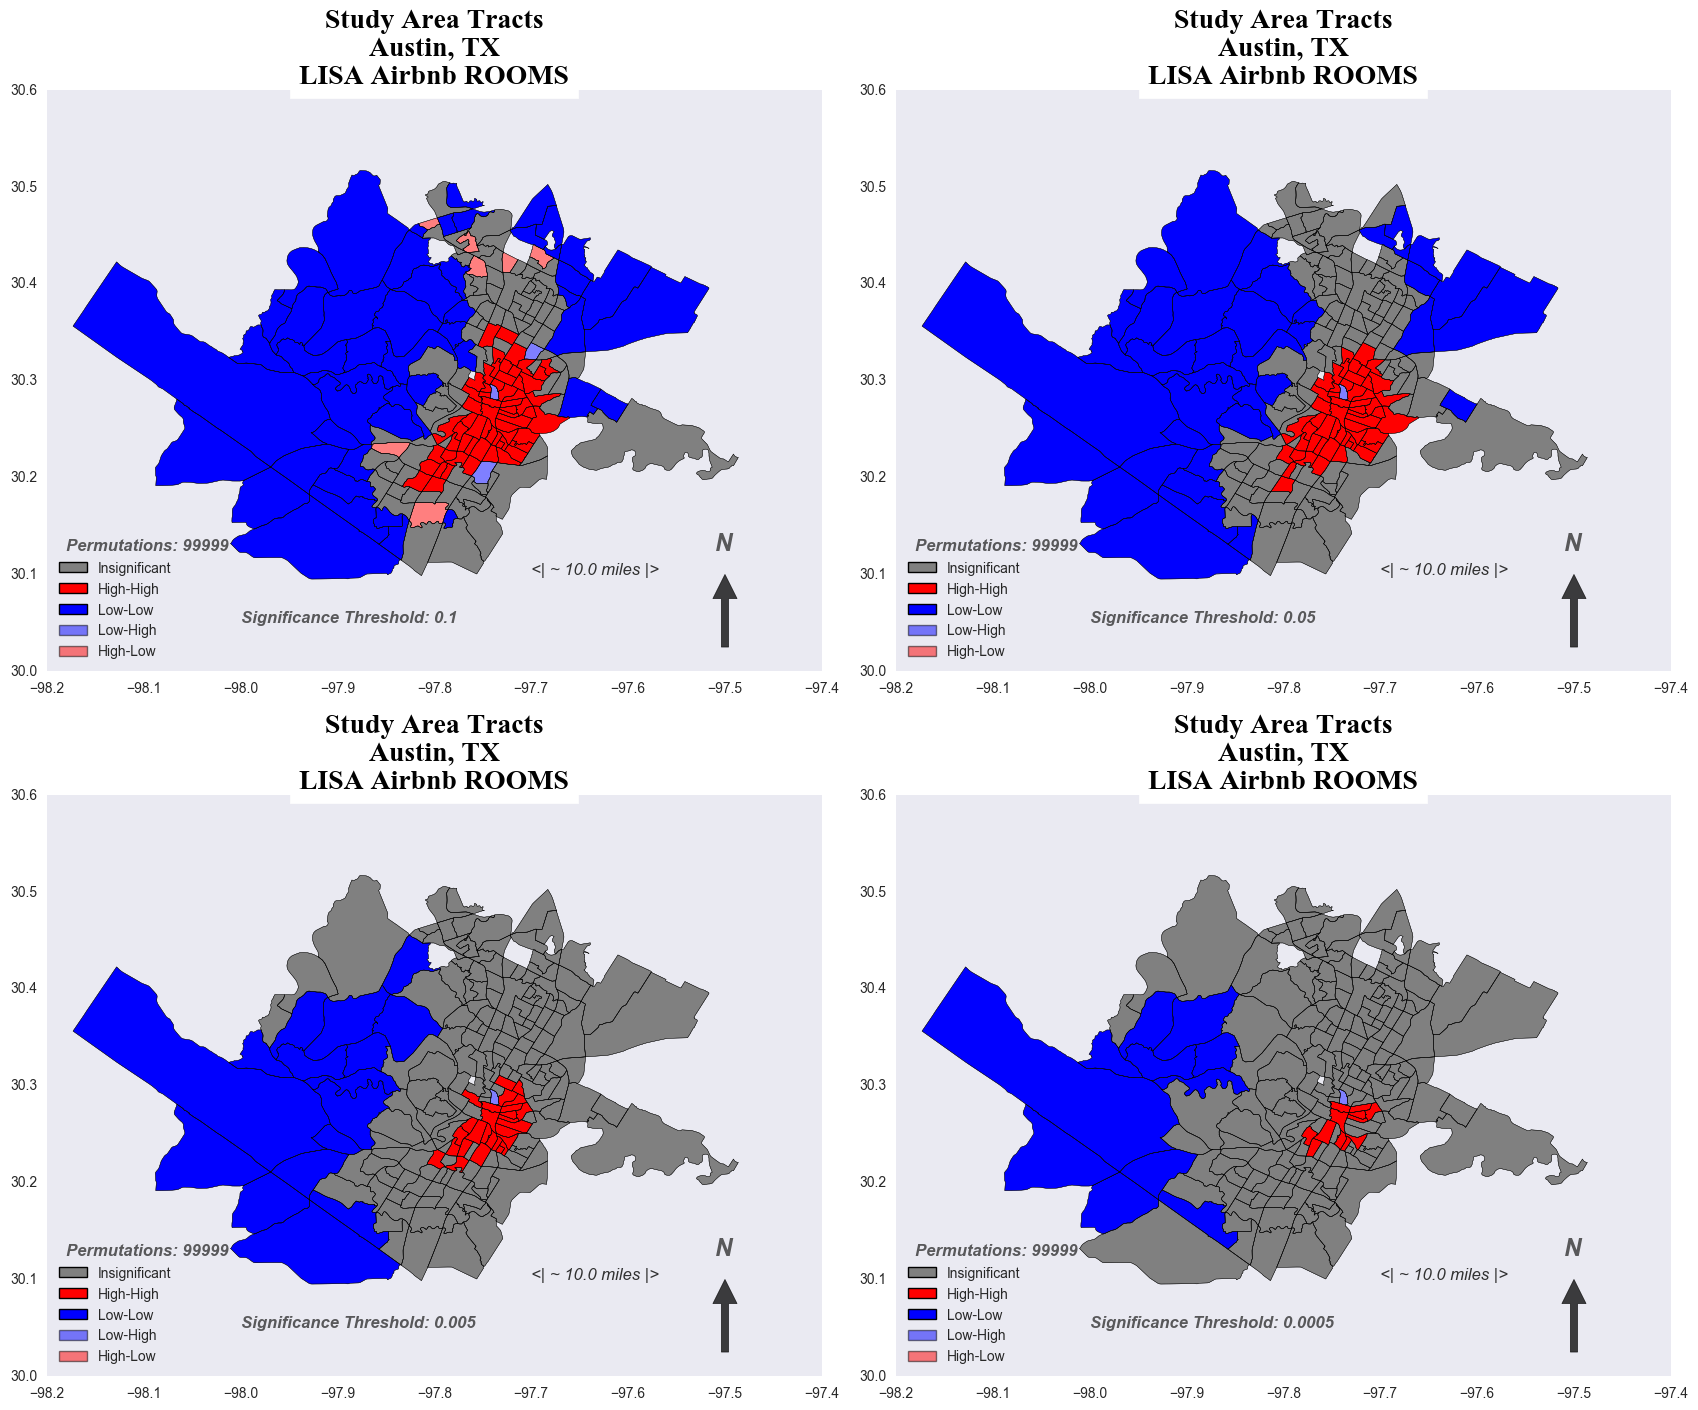

In [117]:
image_dims = (1698,1410)

number_4_ROOM = Image.new("RGB", image_dims, "white")
_1___ = Image.open(maps_tables_figures+"/number_4_ROOM_LISA_0.1.png")
_05__ = Image.open(maps_tables_figures+"/number_4_ROOM_LISA_0.05.png")
_005_ = Image.open(maps_tables_figures+"/number_4_ROOM_LISA_0.005.png")
_0005 = Image.open(maps_tables_figures+"/number_4_ROOM_LISA_0.0005.png")

number_4_ROOM.paste(_1___, (0,0))
number_4_ROOM.paste(_05__, (image_dims[0]/2,0))
number_4_ROOM.paste(_005_, (0,image_dims[1]/2))
number_4_ROOM.paste(_0005, (image_dims[0]/2,image_dims[1]/2))
number_4_ROOM.save(maps_tables_figures+"/number_4_ROOM.png")
number_4_ROOM

## Airbnb Demand $ \textit{Local Moran's } I$

In [118]:
for threshold in significance_levels:
    # Local Moran's I 
    air_demand_Moran_local = ps.Moran_Local(tract_variabes_df_zscore.air_demand, 
                                            w, 
                                            permutations=99999)

    # df, then geodf
    air_demand_Moran_local_df = pd.DataFrame(tract_variabes_df_zscore.GISJOIN)
    air_demand_Moran_local_df = gpd.GeoDataFrame(air_demand_Moran_local_df)
    air_demand_Moran_local_df["Is"] = air_demand_Moran_local.Is
    air_demand_Moran_local_df["p_sim"] = air_demand_Moran_local.p_sim
    air_demand_Moran_local_df["sig"] = air_demand_Moran_local.p_sim < threshold
    air_demand_Moran_local_df['geometry'] = tract_variabes_df_zscore.geometry
    air_demand_Moran_local_df["type"] = air_demand_Moran_local.q
    # slice out insignificant and signficant values
    insig = air_demand_Moran_local_df[air_demand_Moran_local_df["sig"] == False]
    sig = air_demand_Moran_local_df[air_demand_Moran_local_df["sig"] == True]
    high_high = sig[sig["type"] == 1]
    high_low = sig[sig["type"] == 2]
    low_low = sig[sig["type"] == 3]
    low_high = sig[sig["type"] == 4]

    ####################################################################
    # Plot
    mpl.rcParams['figure.figsize'] = 10,10      
    mpl.rcParams['patch.linewidth'] = 0.5      
    mpl.rcParams['markers.fillstyle'] = 'full' 
    # Study Area
    base = tract_shapes.plot(legend=True,
                             cmap=ListedColormap('white'),
                             alpha=1,
                             linewidth=.25)
    # Study Area
    insig.plot(ax=base, 
               cmap=ListedColormap('gray'),
               alpha=1,
               linewidth=.25)
    # HH
    high_high.plot(ax=base, 
                   cmap=ListedColormap('red'),
                   alpha=1,
                   linewidth=.25)
    # HL
    high_low.plot(ax=base, 
                  cmap=ListedColormap('blue'),
                  alpha=.5,
                  linewidth=.25)
    # LH
    low_high.plot(ax=base, 
                  cmap=ListedColormap('red'),
                  alpha=.5,
                  linewidth=.25)
    # LL
    low_low.plot(ax=base, 
                 cmap=ListedColormap('blue'),
                 alpha=1,
                 linewidth=.25)

    # Legend Handles
    NS = mpatches.Patch(facecolor='gray', 
                        edgecolor='black', 
                        lw=1, 
                        label='Insignificant')
    HH = mpatches.Patch(facecolor='red', 
                        edgecolor='black', 
                        lw=1, 
                        label='High-High')
    LL = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        lw=1, 
                        label='Low-Low')
    LH = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        alpha=0.5,
                        lw=1, 
                        label='Low-High')
    HL = mpatches.Patch(facecolor='red', 
                        edgecolor='black',
                        alpha=0.5,
                        lw=1, 
                        label='High-Low')

    # Legend
    plt.legend(handles=[NS, HH, LL, LH, HL], 
               numpoints=1, 
               loc="lower left", 
               shadow=True, 
               framealpha=0.5,
               fancybox=True)

    # Title
    plt.title('Study Area Tracts\nAustin, TX\nLISA Airbnb DEMAND', 
              family='Times New Roman', 
              size=20, 
              color='k', 
              backgroundcolor='w', 
              weight='bold')
    plt.grid(False)

    # Annotations must be changed for different spatial resolutions, etc. ###################
    # Permutations
    plt.annotate('Permutations: '+str(air_demand_Moran_local.permutations), 
                 xy=(-98.18, 30.125), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('Significance Threshold: '+str(threshold), 
                 xy=(-98., 30.05), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('N', xy=(-97.51, 30.125), fontstyle='italic', fontsize='xx-large',
                 fontweight='heavy', alpha=0.75)
    plt.arrow(-97.5, 30.025, 0.0, .05, width=.0075, head_width=.025, 
              head_length=.025, fc='k', ec='k',alpha=0.75,)
    plt.annotate('<| ~ 10.0 miles |>', xy=(-97.7, 30.1), 
                 fontstyle='italic', fontsize='large', alpha=0.95)

    # Save out figure
    plt.savefig(maps_tables_figures+"/number_4_DEMAND_LISA_"+str(threshold)+".png", 
                bbox_inches='tight')
    plt.close()

### Combine

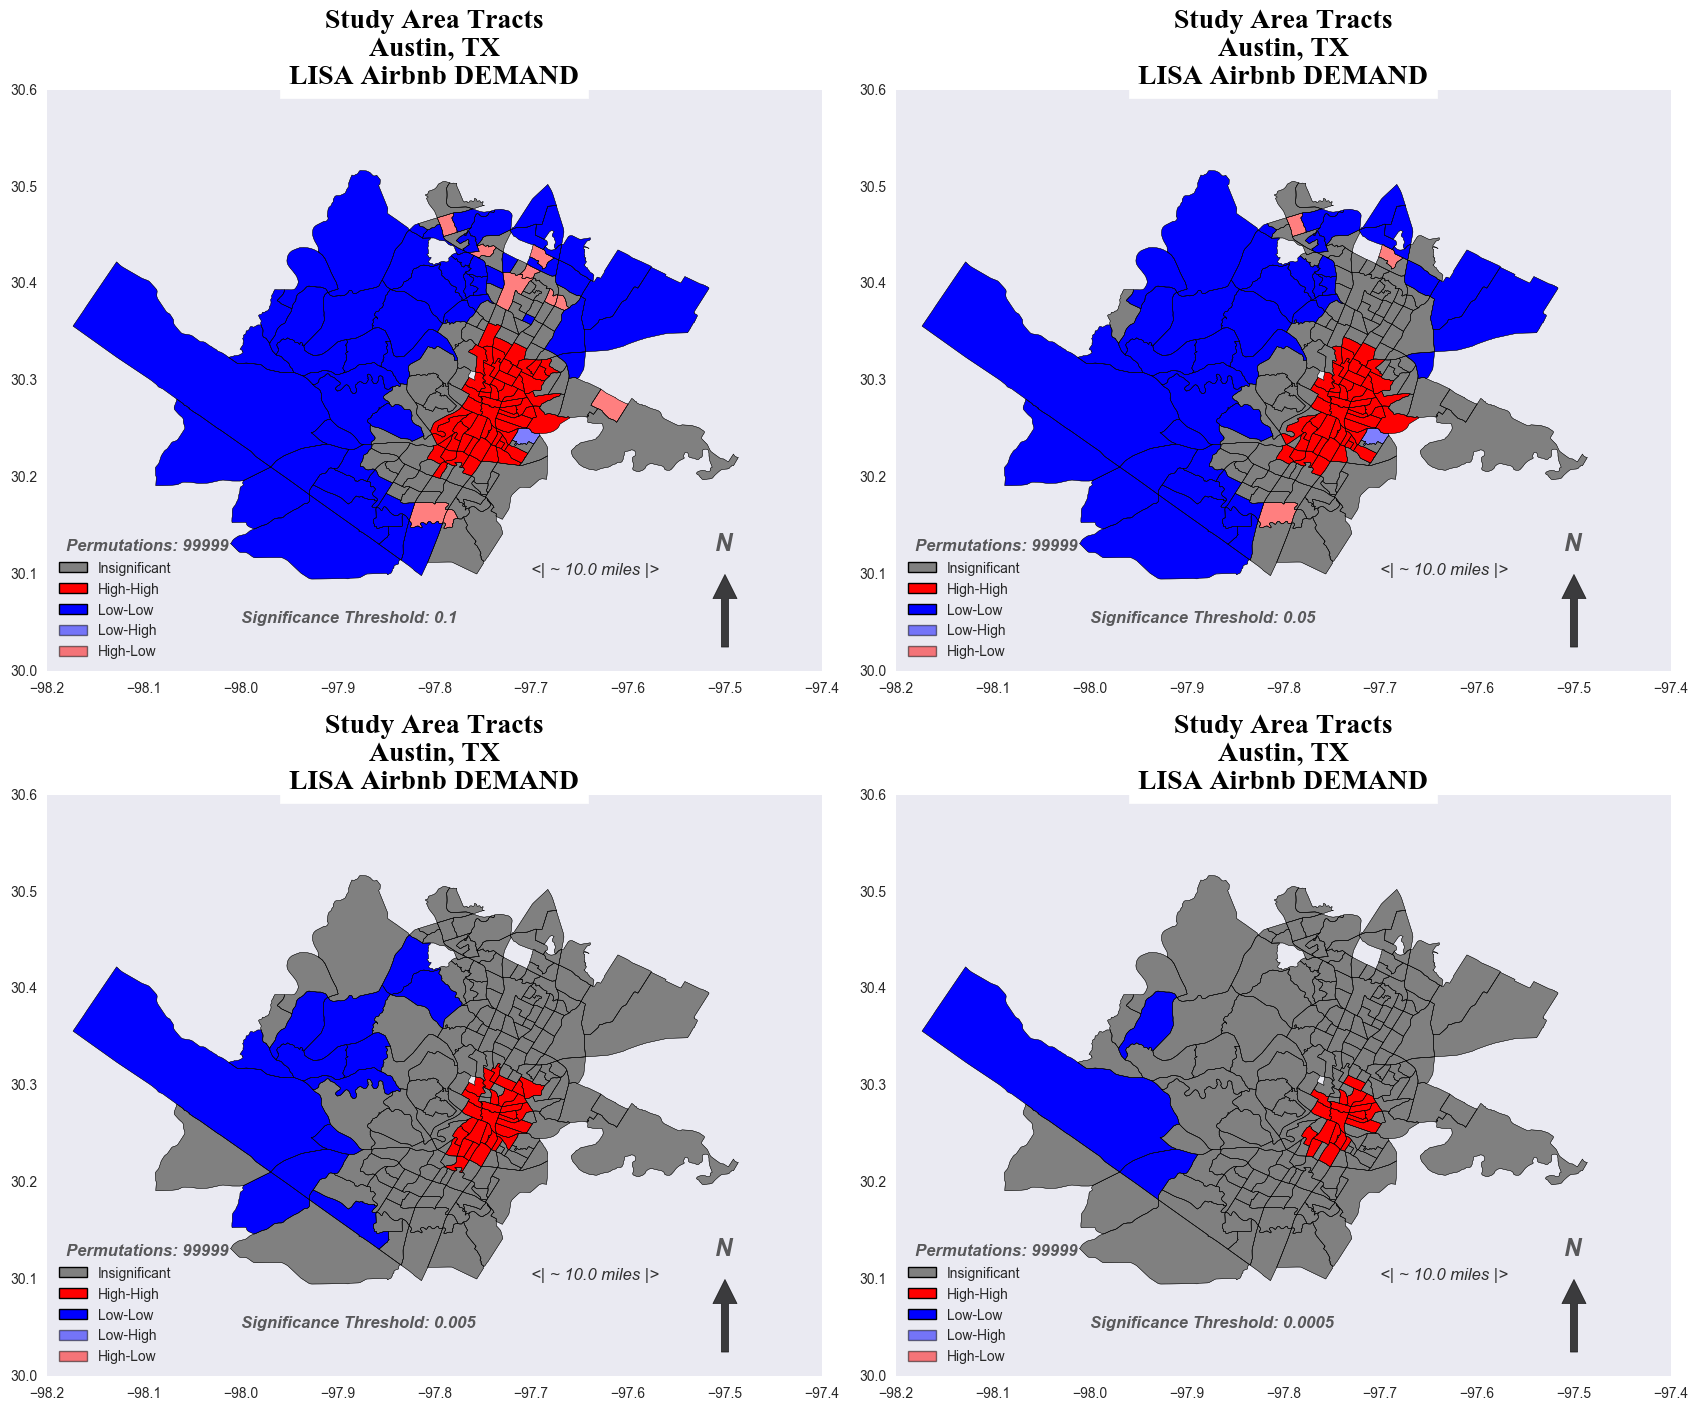

In [119]:
image_dims = (1698,1410)

number_4_DEMAND = Image.new("RGB", image_dims, "white")
_1___ = Image.open(maps_tables_figures+"/number_4_DEMAND_LISA_0.1.png")
_05__ = Image.open(maps_tables_figures+"/number_4_DEMAND_LISA_0.05.png")
_005_ = Image.open(maps_tables_figures+"/number_4_DEMAND_LISA_0.005.png")
_0005 = Image.open(maps_tables_figures+"/number_4_DEMAND_LISA_0.0005.png")

number_4_DEMAND.paste(_1___, (0,0))
number_4_DEMAND.paste(_05__, (image_dims[0]/2,0))
number_4_DEMAND.paste(_005_, (0,image_dims[1]/2))
number_4_DEMAND.paste(_0005, (image_dims[0]/2,image_dims[1]/2))
number_4_DEMAND.save(maps_tables_figures+"/number_4_DEMAND.png")
number_4_DEMAND

## Hotels $ \textit{Local Moran's } I$

In [120]:
for threshold in significance_levels:
    # Local Moran's I 
    air_hotel_Moran_local = ps.Moran_Local(tract_variabes_df_zscore.hot_supply, 
                                           w, 
                                           permutations=99999)

    # df, then geodf
    air_hotel_Moran_local_df = pd.DataFrame(tract_variabes_df_zscore.GISJOIN)
    air_hotel_Moran_local_df = gpd.GeoDataFrame(air_hotel_Moran_local_df)
    air_hotel_Moran_local_df["Is"] = air_hotel_Moran_local.Is
    air_hotel_Moran_local_df["p_sim"] = air_hotel_Moran_local.p_sim
    air_hotel_Moran_local_df["sig"] = air_hotel_Moran_local.p_sim < threshold
    air_hotel_Moran_local_df['geometry'] = tract_variabes_df_zscore.geometry
    air_hotel_Moran_local_df["type"] = air_hotel_Moran_local.q
    # slice out insignificant and signficant values
    insig = air_hotel_Moran_local_df[air_hotel_Moran_local_df["sig"] == False]
    sig = air_hotel_Moran_local_df[air_hotel_Moran_local_df["sig"] == True]
    high_high = sig[sig["type"] == 1]
    high_low = sig[sig["type"] == 2]
    low_low = sig[sig["type"] == 3]
    low_high = sig[sig["type"] == 4]

    ####################################################################
    # Plot
    mpl.rcParams['figure.figsize'] = 10,10      
    mpl.rcParams['patch.linewidth'] = 0.5      
    mpl.rcParams['markers.fillstyle'] = 'full' 
    # Study Area
    base = tract_shapes.plot(legend=True,
                             cmap=ListedColormap('white'),
                             alpha=1,
                             linewidth=.25)
    # Study Area
    insig.plot(ax=base, 
               cmap=ListedColormap('gray'),
               alpha=1,
               linewidth=.25)
    # HH
    high_high.plot(ax=base, 
                   cmap=ListedColormap('red'),
                   alpha=1,
                   linewidth=.25)
    # HL
    high_low.plot(ax=base, 
                  cmap=ListedColormap('blue'),
                  alpha=.5,
                  linewidth=.25)
    # LH
    low_high.plot(ax=base, 
                  cmap=ListedColormap('red'),
                  alpha=.5,
                  linewidth=.25)
    # LL
    low_low.plot(ax=base, 
                 cmap=ListedColormap('blue'),
                 alpha=1,
                 linewidth=.25)

    # Legend Handles
    NS = mpatches.Patch(facecolor='gray', 
                        edgecolor='black', 
                        lw=1, 
                        label='Insignificant')
    HH = mpatches.Patch(facecolor='red', 
                        edgecolor='black', 
                        lw=1, 
                        label='High-High')
    LL = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        lw=1, 
                        label='Low-Low')
    LH = mpatches.Patch(facecolor='blue', 
                        edgecolor='black', 
                        alpha=0.5,
                        lw=1, 
                        label='Low-High')
    HL = mpatches.Patch(facecolor='red', 
                        edgecolor='black',
                        alpha=0.5,
                        lw=1, 
                        label='High-Low')

    # Legend
    plt.legend(handles=[NS, HH, LL, LH, HL], 
               numpoints=1, 
               loc="lower left", 
               shadow=True, 
               framealpha=0.5,
               fancybox=True)

    # Title
    plt.title('Study Area Tracts\nAustin, TX\nLISA Hotels', 
              family='Times New Roman', 
              size=20, 
              color='k', 
              backgroundcolor='w', 
              weight='bold')
    plt.grid(False)

    # Annotations must be changed for different spatial resolutions, etc. ###################
    # Permutations
    plt.annotate('Permutations: '+str(air_hotel_Moran_local.permutations), 
                 xy=(-98.18, 30.125), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('Significance Threshold: '+str(threshold), 
                 xy=(-98., 30.05), fontstyle='italic', fontsize='large',
                 fontweight='heavy', alpha=0.75)
    plt.annotate('N', xy=(-97.51, 30.125), fontstyle='italic', fontsize='xx-large',
                 fontweight='heavy', alpha=0.75)
    plt.arrow(-97.5, 30.025, 0.0, .05, width=.0075, head_width=.025, 
              head_length=.025, fc='k', ec='k',alpha=0.75,)
    plt.annotate('<| ~ 10.0 miles |>', xy=(-97.7, 30.1), 
                 fontstyle='italic', fontsize='large', alpha=0.95)

    # Save out figure
    plt.savefig(maps_tables_figures+"/number_4_HOTEL_LISA_"+str(threshold)+".png",
                bbox_inches='tight')
    plt.close()

### Combine

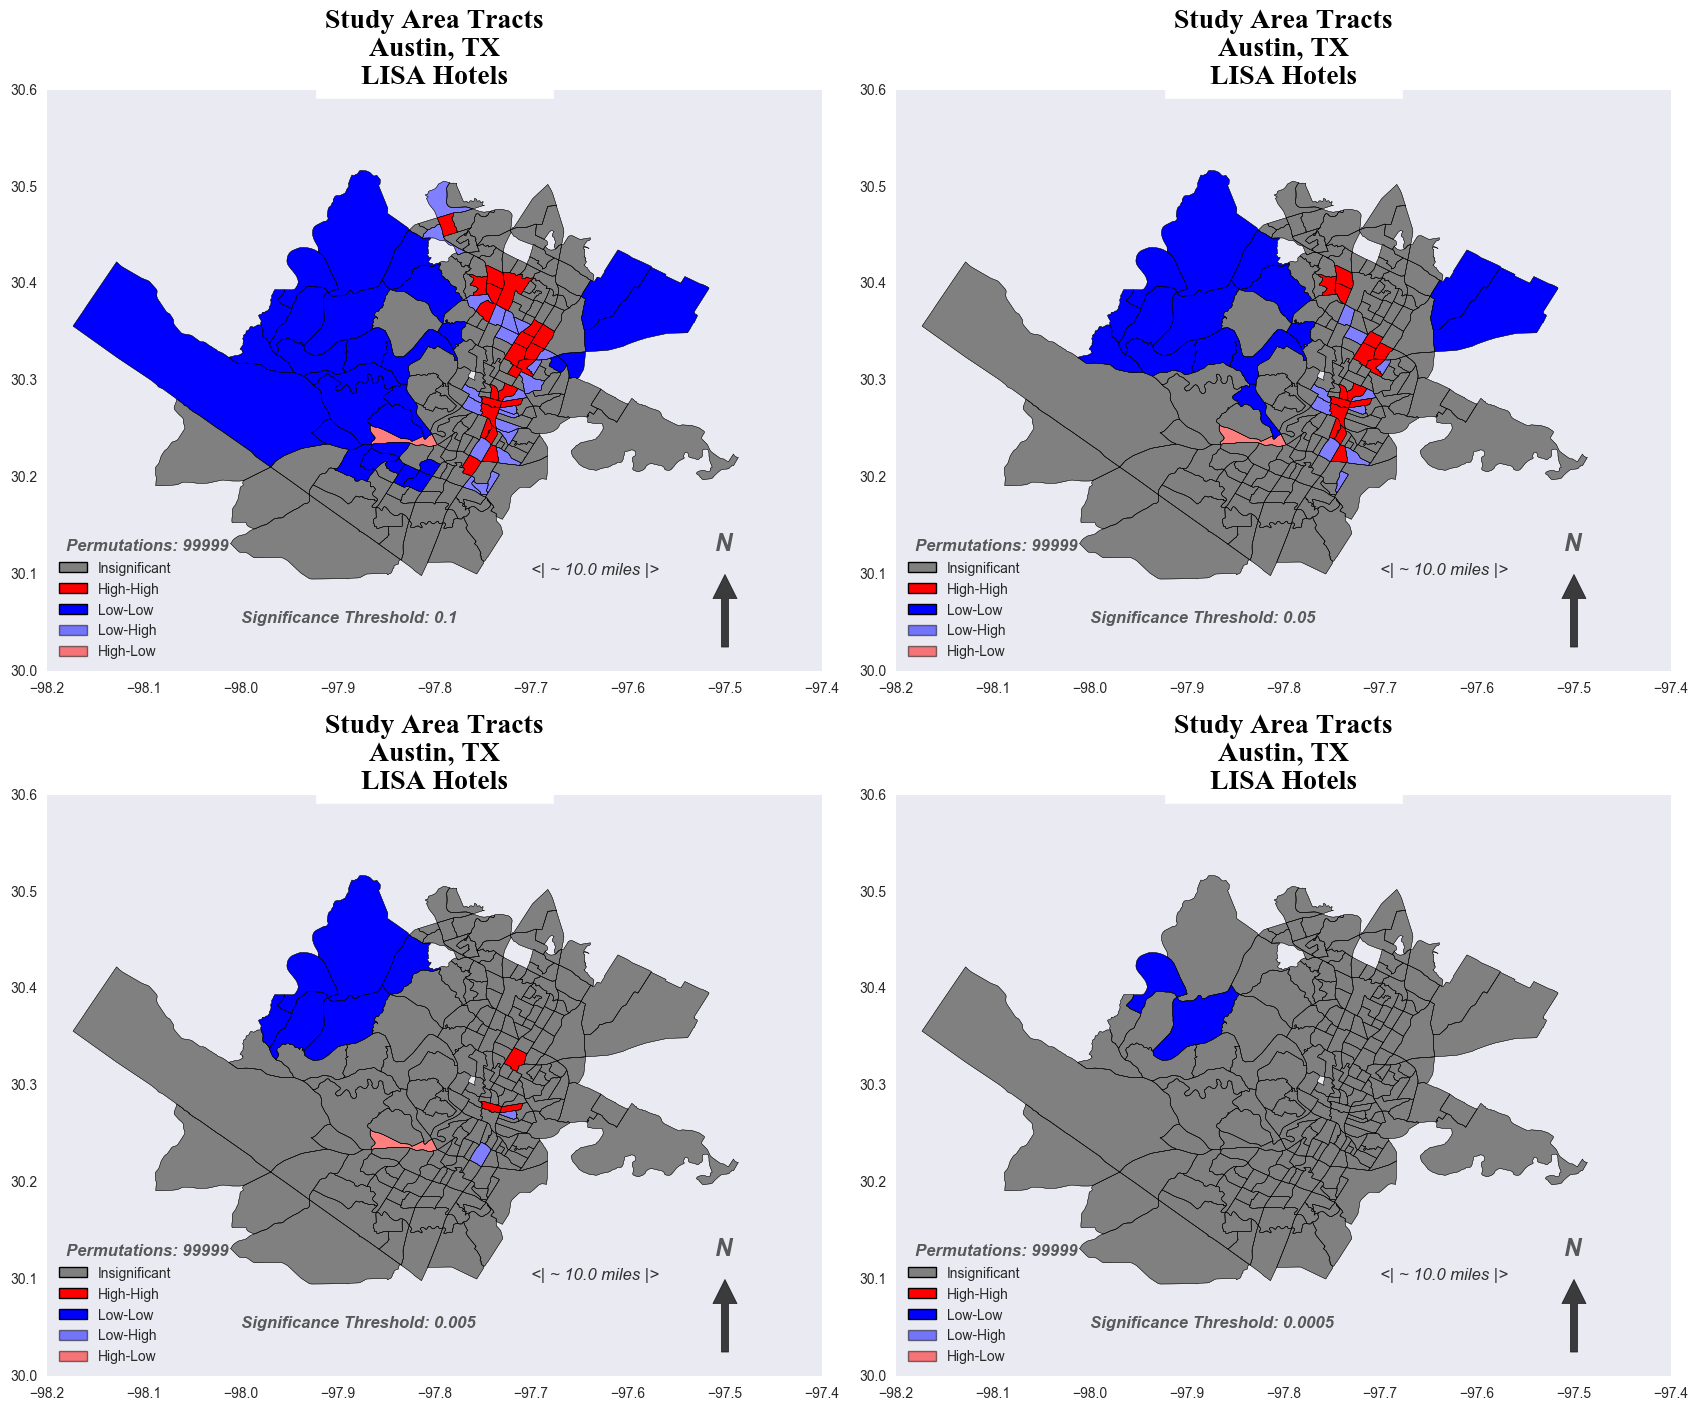

In [121]:
image_dims = (1698,1410)

number_4_HOTEL = Image.new("RGB", image_dims, "white")
_1___ = Image.open(maps_tables_figures+"/number_4_HOTEL_LISA_0.1.png")
_05__ = Image.open(maps_tables_figures+"/number_4_HOTEL_LISA_0.05.png")
_005_ = Image.open(maps_tables_figures+"/number_4_HOTEL_LISA_0.005.png")
_0005 = Image.open(maps_tables_figures+"/number_4_HOTEL_LISA_0.0005.png")

number_4_HOTEL.paste(_1___, (0,0))
number_4_HOTEL.paste(_05__, (image_dims[0]/2,0))
number_4_HOTEL.paste(_005_, (0,image_dims[1]/2))
number_4_HOTEL.paste(_0005, (image_dims[0]/2,image_dims[1]/2))
number_4_HOTEL.save(maps_tables_figures+"/number_4_HOTEL.png")
number_4_HOTEL

--------------------------------

----------------------

# \# 6

### Regression analyses

### Workflow

- Run OLS Regression
- Are the Lagrange Multiplier - Error or Lag significant?
    - no: STOP
    - yes: one: Error: Run Spatial Error
    - yes: one: Lag: Run Spatial Lag
    - yes: both: Run Robust LM Error and Lag       
- Are the Robust Lagrange Multiplier - Error or Lag significant?
    - no: STOP
    - yes: one: Error: Run Spatial Error
    - yes: one: Lag: Run Spatial Lag
    - yes: both: Choose the more significant
    - yes: both: Equally significant: Choose the higher $ \beta $

In [496]:
# Adding signficance indicators to coefficients
def sig_stars(data, prob):
    star = '*'
    for num in range(len(data)):
        if prob[num] >=.1:
            data[num] = str(round(prob[num],5))
        if prob[num] <.1 and prob[num] >= .05:
            data[num] = str(round(prob[num],5))+star
        if prob[num] < .05 and prob[num] >= .005:
            data[num] = str(round(prob[num],5))+star*2
        if prob[num] < .005:
            data[num] = str(round(prob[num],5))+star*3
    return data

### Building input

In [559]:
y_var_names = ['air_supply', 'air_unit', 'air_room', 'air_demand']
y_var_values = np.array([tract_variabes_df_zscore.air_supply,
                         tract_variabes_df_zscore.air_unit,
                         tract_variabes_df_zscore.air_room,
                         tract_variabes_df_zscore.air_demand])
x_var_names = ['transportation', 'young', 'income', 'employment', 'bohemia',
               'melting_pot', 'education', 'substandard', 'multifamily', 'rental',
               'fancy', 'house_price', 'Simpson', 'hot_supply', 'attraction']
x_var_values = np.array([tract_variabes_df_zscore.transportation,
                         tract_variabes_df_zscore.young,
                         tract_variabes_df_zscore.income,
                         tract_variabes_df_zscore.employment,
                         tract_variabes_df_zscore.bohemia,
                         tract_variabes_df_zscore.melting_pot,
                         tract_variabes_df_zscore.education,
                         tract_variabes_df_zscore.substandard,
                         tract_variabes_df_zscore.multifamily,
                         tract_variabes_df_zscore.rental,
                         tract_variabes_df_zscore.fancy,
                         tract_variabes_df_zscore.house_price,
                         tract_variabes_df_zscore.Simpson,
                         tract_variabes_df_zscore.hot_supply,
                         tract_variabes_df_zscore.attraction]).T
index = independant_vars + ["rho / lambda","FIT", "LMe", "LMl", "rLMe", "rLMr", "Model"]
reg_results_df = pd.DataFrame(index=index)

## Regressions

In [563]:
tests = xrange(len(y_var_names))
for test in tests:
    y = y_var_values[test].reshape(201,1)
    X = x_var_values
    name_y= y_var_names[test] 
    name_x = independant_vars
    ols = ps.spreg.OLS(y, 
                       X,
                       w=w,
                       spat_diag=True,
                       name_y=name_y, 
                       name_x=name_x, 
                       name_ds='Austin')
    
    # Neither Lagrange Multipliers are significant
    if ols.lm_error[1] > .1 and ols.lm_lag[1] > .1:
        print "Neither Lagrange Multipliers are significant " + name_y
        coefs = sig_stars([ols.betas[var][0]\
                           for var in range(1,len(ols.betas))],
                           [ols.t_stat[var][1]\
                           for var in range(1,len(ols.t_stat))])
        spatial = ["not spatial"]
        fit = [ols.r2, "r^2"]
        lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
        lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
        rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
        rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
        #title = [ols.title]
        title = ["OLS"]
        reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
        reg_results_df[name_y] = reg_results

    # Lagrange Multipliers - Error is significant: Run Spatial Error.
    if ols.lm_error[1] <= .1 and ols.lm_lag[1] > .1:
        print "Lagrange Multipliers - Error is significant: Run Spatial Error. " + name_y
        ml_error = ps.spreg.ML_Error(y, 
                             X,
                             w=w,
                             name_y=name_y, 
                             name_x=name_x, 
                             name_ds='Austin')
        coefs = sig_stars([ml_error.betas[var][0]\
                           for var in range(1,len(ml_error.betas)-1)],
                           [ml_error.z_stat[var][1]\
                           for var in range(1,len(ml_error.z_stat)-1)])
        spatial = [ml_error.lam]
        fit = [ml_error.pr2]
        lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
        lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
        rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
        rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
        #title = [ml_error.title]
        title = ["Spatial Error"]
        reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
        reg_results_df[name_y] = reg_results
        
    # Lagrange Multipliers - Lag is significant: Run Spatial Lag.
    if ols.lm_error[1] > .1 and ols.lm_lag[1] <= .1:
        print "Lagrange Multipliers - Lag is significant: Run Spatial Lag. " + name_y
        ml_lag = ps.spreg.ML_Lag(y, 
                                 X,
                                 w=w,
                                 name_y=name_y, 
                                 name_x=name_x, 
                                 name_ds='Austin')
        coefs = sig_stars([ml_lag.betas[var][0]\
                           for var in range(1,len(ml_lag.betas)-1)],
                           [ml_lag.z_stat[var][1]\
                           for var in range(1,len(ml_lag.z_stat)-1)])
        spatial = [ml_lag.rho]
        fit = [ml_lag.pr2]
        lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
        lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
        rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
        rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
        #title = [ml_lag.title]
        title = ["Spatial Lag"]
        reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
        reg_results_df[name_y] = reg_results

    # Both Lagrange Multipliers are significant: Check Robust LM Error and Lag
    if ols.lm_error[1] <= .1 and ols.lm_lag[1] <= .1:
        print "Both Lagrange Multipliers are significant: Check Robust LM Error and Lag " + name_y
        
        # Robust Lagrange Multipliers - Error is significant: Run Spatial Error.
        if ols.rlm_error[1] <= .1 and ols.rlm_lag[1] > .1:
            print "Robust Lagrange Multipliers - Error is significant: Run Spatial Error " + name_y
            ml_error = ps.spreg.ML_Error(y, 
                             X,
                             w=w,
                             name_y=name_y, 
                             name_x=name_x, 
                             name_ds='Austin')
            coefs = sig_stars([ml_error.betas[var][0]\
                               for var in range(1,len(ml_error.betas)-1)],
                               [ml_error.z_stat[var][1]\
                               for var in range(1,len(ml_error.z_stat)-1)])
            spatial = [ml_error.lam]
            fit = [ml_error.pr2]
            lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
            lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
            rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
            rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
            #title = [ml_error.title]
            title = ["Spatial Error"]
            reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
            reg_results_df[name_y] = reg_results
        
        # Robust Lagrange Multipliers - Lag is significant: Run Spatial Lag.
        if ols.rlm_error[1] > .1 and ols.rlm_lag[1] <= .1:
            print "Robust Lagrange Multipliers - Lag is significant: Run Spatial Lag. " + name_y
            ml_lag = ps.spreg.ML_Lag(y, 
                                     X,
                                     w=w,
                                     name_y=name_y, 
                                     name_x=name_x, 
                                     name_ds='Austin')
            coefs = sig_stars([ml_lag.betas[var][0]\
                               for var in range(1,len(ml_lag.betas)-1)],
                               [ml_lag.z_stat[var][1]\
                               for var in range(1,len(ml_lag.z_stat)-1)])
            spatial = [ml_lag.rho]
            fit = [ml_lag.pr2]
            lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
            lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
            rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
            rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
            #title = [ml_lag.title]
            title = ["Spatial Lag"]
            reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
            reg_results_df[name_y] = reg_results
        
        # Both Robust Lagrange Multipliers are significant
        if ols.rlm_error[1] <= .1 and ols.rlm_lag[1] <= .1:
            print "Both Robust Lagrange Multipliers are significant " + name_y
            
            # Robust Lagrange Multiplier - Error more significant
            if ols.rlm_error[1] < ols.rlm_lag[1]:
                print "Robust Lagrange Multiplier - Error more significant " + name_y
                ml_error = ps.spreg.ML_Error(y, 
                             X,
                             w=w,
                             name_y=name_y, 
                             name_x=name_x, 
                             name_ds='Austin')
                coefs = sig_stars([ml_error.betas[var][0]\
                                   for var in range(1,len(ml_error.betas)-1)],
                                   [ml_error.z_stat[var][1]\
                                   for var in range(1,len(ml_error.z_stat)-1)])
                spatial = [ml_error.lam]
                fit = [ml_error.pr2]
                lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
                lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
                rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
                rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
                #title = [ml_error.title]
                title = ["Spatial Error"]
                reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
                reg_results_df[name_y] = reg_results
        
            # Robust Lagrange Multiplier - Lag more significant
            if ols.rlm_error[1] > ols.rlm_lag[1]:
                print "Robust Lagrange Multiplier - Lag more significant " + name_y
                ml_lag = ps.spreg.ML_Lag(y, 
                                     X,
                                     w=w,
                                     name_y=name_y, 
                                     name_x=name_x, 
                                     name_ds='Austin')
                coefs = sig_stars([ml_lag.betas[var][0]\
                                   for var in range(1,len(ml_lag.betas)-1)],
                                   [ml_lag.z_stat[var][1]\
                                   for var in range(1,len(ml_lag.z_stat)-1)])
                spatial = [ml_lag.rho]
                fit = [ml_lag.pr2]
                lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
                lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
                rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
                rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
                #title = [ml_lag.title]
                title = ["Spatial Lag"]
                reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
                reg_results_df[name_y] = reg_results
            
            # Both Robust Lagrange Multipliers are significant
            if ols.rlm_error[1] <= .1 and ols.rlm_lag[1] <= .1:
                print "Both Robust Lagrange Multipliers are significant:"
                print "Check test statistic " + name_y
                if ols.rlm_error[0] > ols.rlm_lag[0]:
                    print "Error test statistic larger " + name_y
                    ml_error = ps.spreg.ML_Error(y, 
                                 X,
                                 w=w,
                                 name_y=name_y, 
                                 name_x=name_x, 
                                 name_ds='Austin')
                    coefs = sig_stars([ml_error.betas[var][0]\
                                       for var in range(1,len(ml_error.betas)-1)],
                                       [ml_error.z_stat[var][1]\
                                       for var in range(1,len(ml_error.z_stat)-1)])
                    spatial = [ml_error.lam]
                    fit = [ml_error.pr2]
                    lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
                    lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
                    rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
                    rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
                    #title = [ml_error.title]
                    title = ["Spatial Error"]
                    reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
                    reg_results_df[name_y] = reg_results
                
                if ols.rlm_error[0] < ols.rlm_lag[0]:
                    print "Lag test statistic larger " + name_y
                    ml_lag = ps.spreg.ML_Lag(y, 
                                     X,
                                     w=w,
                                     name_y=name_y, 
                                     name_x=name_x, 
                                     name_ds='Austin')
                    coefs = sig_stars([ml_lag.betas[var][0]\
                                       for var in range(1,len(ml_lag.betas)-1)],
                                       [ml_lag.z_stat[var][1]\
                                       for var in range(1,len(ml_lag.z_stat)-1)])
                    spatial = [ml_lag.rho]
                    fit = [ml_lag.pr2]
                    lme = sig_stars([ols.lm_error[0]], [ols.lm_error[1]])
                    lml = sig_stars([ols.lm_lag[0]], [ols.lm_lag[1]])
                    rlme = sig_stars([ols.rlm_error[0]], [ols.rlm_error[1]])
                    rlml = sig_stars([ols.rlm_lag[0]], [ols.rlm_lag[1]])
                    #title = [ml_lag.title]
                    title = ["Spatial Lag"]
                    reg_results = coefs + spatial + fit + lme + lml + rlme + rlml + title
                    reg_results_df[name_y] = reg_results            

Both Lagrange Multipliers are significant: Check Robust LM Error and Lag air_supply
Robust Lagrange Multipliers - Lag is significant: Run Spatial Lag. air_supply
Both Lagrange Multipliers are significant: Check Robust LM Error and Lag air_unit
Robust Lagrange Multipliers - Lag is significant: Run Spatial Lag. air_unit
Both Lagrange Multipliers are significant: Check Robust LM Error and Lag air_room
Robust Lagrange Multipliers - Lag is significant: Run Spatial Lag. air_room
Both Lagrange Multipliers are significant: Check Robust LM Error and Lag air_demand
Robust Lagrange Multipliers - Lag is significant: Run Spatial Lag. air_demand


## Regression Results

In [564]:
reg_results_df

,air_supply,air_unit,air_room,air_demand
transportation,0.20359,0.34953,0.81359,0.6771
young,0.4819,0.49569,0.89694,0.59501
income,0.0003***,1e-05***,0.00046***,0.0079**
employment,0.03551**,0.00656**,0.04767**,0.11814
bohemia,0.12372,0.20727,0.03918**,0.51227
melting_pot,0.85629,0.16342,0.92821,0.33231
education,7e-05***,0.00715**,0.00088***,0.04401**
substandard,0.2743,0.1533,0.06731*,0.37741
multifamily,0.00383***,0.43813,0.02473**,0.03433**
rental,0.04725**,0.77395,0.54831,0.11643


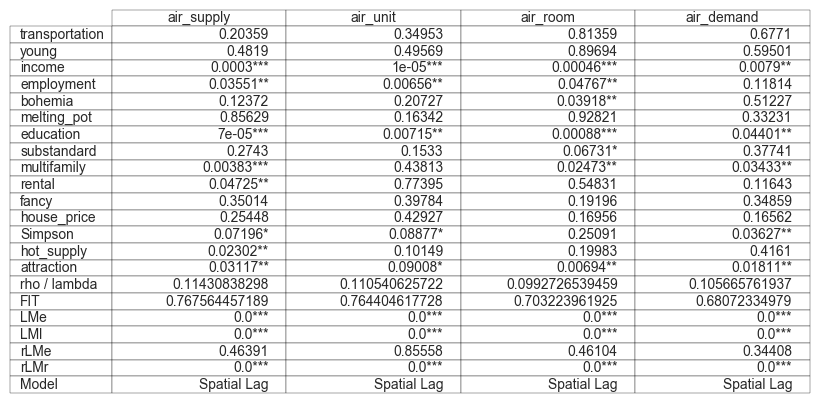

In [578]:
mpl.rcParams['figure.figsize'] = 9,2

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, reg_results_df, loc='center')  # where df is your data frame

plt.savefig(maps_tables_figures+'/number_6_reg_results_df.png', bbox_inches='tight')
plt.show()

---------------